# 과적합 Label Smoothing

In [1]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True) 

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def imshow(img):
    img = .5 * img + .5
    plt.figure(figsize=(10,100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

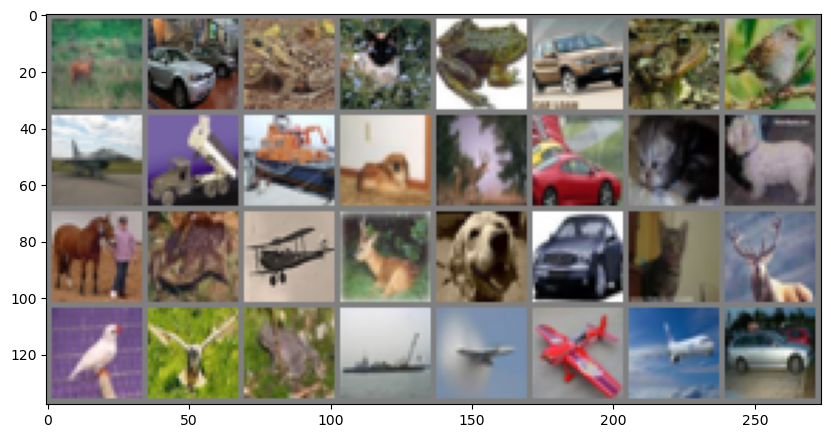

torch.Size([32, 3, 32, 32])


In [4]:
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images,nrow=8))
print(images.size())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


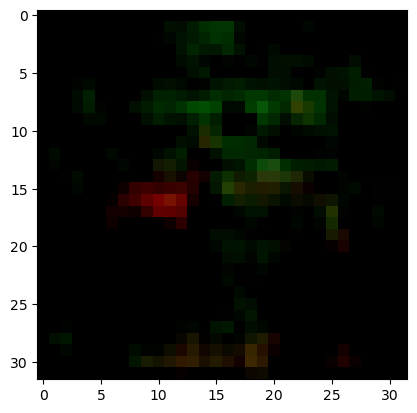

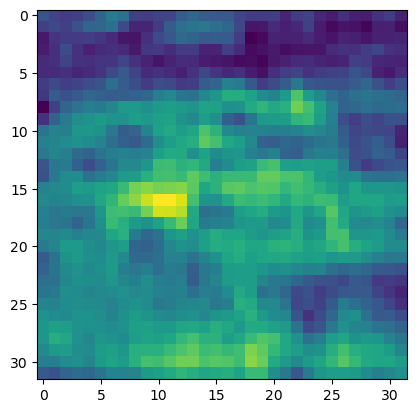

In [13]:
plt.imshow(images[0,:,:].permute(1,2,0))
plt.figure()
plt.imshow(images[0,0,:,:])

In [16]:
PATH = './models/cifar_resnet_labelsmoothing.pth'

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
resnet = models.resnet18()

In [20]:
resnet.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [21]:
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

In [22]:
resnet.conv1

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [23]:
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [24]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(nn.Dropout2d(0.5), nn.Linear(num_ftrs, 10))
resnet.fc

Sequential(
  (0): Dropout2d(p=0.5, inplace=False)
  (1): Linear(in_features=512, out_features=10, bias=True)
)

In [25]:
resnet = resnet.to(device)

In [26]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim) # Cross Entropy 부분의 log softmax 미리 계산하기
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred) # 예측값과 동일한 크기의 영텐서 만들기
            true_dist.fill_(self.smoothing / (self.cls - 1)) # alpha/(K-1)을 만들어 줌(alpha/K로 할 수도 있음)
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) # (1-alpha)y + alpha/(K-1)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim)) # Cross Entropy Loss 계산

In [27]:
criterion = LabelSmoothingLoss(classes=10, smoothing=0.2)
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [30]:
criterion, optimizer

(LabelSmoothingLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [31]:
from tqdm import tqdm

In [32]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainloader) # 배치 개수

for epoch in tqdm(range(20)): 

    running_loss = 0.0
    for data in trainloader:

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터    

        optimizer.zero_grad()

        outputs = resnet(inputs) # 예측값 산출 

        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        running_loss += loss.item()

    loss_.append(running_loss / n)    
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / n))
    torch.save(resnet.state_dict(), PATH) ###

print('Finished Training')

  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\user\mambaforge\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
  5%|▌         | 1/20 [00:58<18:26, 58.24s/it]

[1] loss: 1.707


 10%|█         | 2/20 [01:35<13:50, 46.13s/it]

[2] loss: 1.440


 15%|█▌        | 3/20 [02:13<12:01, 42.47s/it]

[3] loss: 1.329


 20%|██        | 4/20 [02:51<10:50, 40.66s/it]

[4] loss: 1.251


 25%|██▌       | 5/20 [03:29<09:53, 39.57s/it]

[5] loss: 1.189


 30%|███       | 6/20 [04:09<09:15, 39.69s/it]

[6] loss: 1.133


 35%|███▌      | 7/20 [04:47<08:29, 39.17s/it]

[7] loss: 1.089


 40%|████      | 8/20 [05:25<07:47, 38.92s/it]

[8] loss: 1.060


 45%|████▌     | 9/20 [06:05<07:10, 39.11s/it]

[9] loss: 1.036


 50%|█████     | 10/20 [06:46<06:37, 39.73s/it]

[10] loss: 1.020


 55%|█████▌    | 11/20 [07:25<05:54, 39.42s/it]

[11] loss: 1.012


 60%|██████    | 12/20 [08:12<05:35, 41.89s/it]

[12] loss: 1.003


 65%|██████▌   | 13/20 [10:06<07:26, 63.73s/it]

[13] loss: 0.997


 70%|███████   | 14/20 [12:00<07:52, 78.74s/it]

[14] loss: 0.994


 75%|███████▌  | 15/20 [13:53<07:26, 89.28s/it]

[15] loss: 0.988


 80%|████████  | 16/20 [15:47<06:26, 96.56s/it]

[16] loss: 0.986


 85%|████████▌ | 17/20 [17:00<04:28, 89.58s/it]

[17] loss: 0.984


 90%|█████████ | 18/20 [17:27<02:21, 70.75s/it]

[18] loss: 0.979


 95%|█████████▌| 19/20 [17:55<00:57, 57.87s/it]

[19] loss: 0.979


100%|██████████| 20/20 [18:22<00:00, 55.13s/it]

[20] loss: 0.977
Finished Training


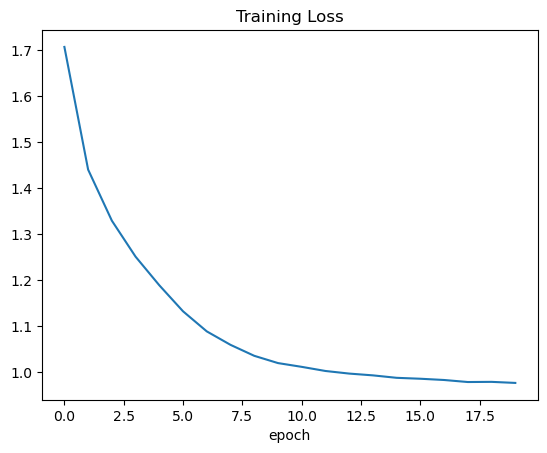

In [33]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [34]:
resnet = models.resnet18()
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(nn.Dropout2d(0.5), nn.Linear(num_ftrs, 10))
resnet = resnet.to(device)
resnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [35]:
correct = 0
total = 0
with torch.no_grad():
    resnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        print(f'예측 : {predicted}')
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print((predicted == labels).sum())
        
print('Test accuracy: %.2f %%' % (100 * correct / total))

c:\Users\user\mambaforge\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


예측 : tensor([3, 8, 1, 0, 6, 6, 1, 6, 3, 1, 0, 9, 4, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5], device='cuda:0')
tensor(30, device='cuda:0')
예측 : tensor([4, 5, 9, 8, 4, 9, 9, 5, 4, 6, 5, 6, 0, 9, 3, 3, 7, 6, 9, 8, 0, 3, 8, 8,
        7, 5, 3, 3, 7, 5, 6, 3], device='cuda:0')
tensor(25, device='cuda:0')
예측 : tensor([6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 0, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7,
        8, 9, 0, 3, 8, 6, 4, 6], device='cuda:0')
tensor(31, device='cuda:0')
예측 : tensor([6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 6, 0, 2, 2, 1, 3, 0, 4, 2, 7,
        8, 0, 1, 2, 8, 2, 8, 3], device='cuda:0')
tensor(28, device='cuda:0')
예측 : tensor([2, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 1, 6, 5, 6, 3, 8, 7, 6, 6, 2, 2, 8, 9,
        6, 0, 6, 5, 2, 9, 3, 4], device='cuda:0')
tensor(26, device='cuda:0')
예측 : tensor([0, 1, 6, 6, 2, 2, 8, 4, 5, 0, 9, 0, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2,
        0, 8, 6, 3, 3, 8, 5, 8], device='cuda:0')
tensor(25, device='cuda:0')
예측 : tensor([0, 1, 7, 

In [36]:
tensor(30, device='cuda:0').item()

NameError: name 'tensor' is not defined